# ODE predictions of inputs
### Katherine Duncker
#### 4/11/2025
#### You Lab

## Import necessary packages and define device for torch

In [1]:
#import python packages
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import glob
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

#import data loading and pre-processing functions from separate .py files
from data_loading_v5 import define_metadata, import_exp_data, filter_dataframes, process_dataframes, convert_reader_data, subtract,normalize 
from plot_timecourses import plottimecourselist, plottimecoursearray, figure_layout 
from crosstalk import crosstalk, mixed_crosstalk, antibiotic_crosstalk
from dose_response_fitting import dose_response_fitting
from mechanistic_model import difeq_newest_test_2, fp_total_timecourse, sensor_fit, plot_fittings
from VAE import VAE, train, test, warmup_scheduler, get_latent_variables, count_parameters
from VAEMLP import MLP, CombinedModel, combo_train, validate

## Select which community to use and process data

In [2]:
#select which microbial community dataset to work with
community='aTc_IPTG' #list of options: 'aTc_IPTG','TTR_THS','cuma_ohc_atc','van_dapg_nar', 'antibiotic_data', 'ttr_ths_ph'

#if using antibiotic data, indicate the plasmid and inhibitor combination
plasmid='BlaM' #options: 'Bla', 'BlaM', 'HSGBla', 'HSGBlaM'
inhibitor='SUL' #options: 'TAZ', 'SUL'
if community!='antibiotic_data':
    plasmid=None
    inhibitor=None

#import metadata for selected community
files,readers, fluors, fluor1, fluor2, fluor3, single_file, sensor_names, sensors,time_vector,od_raws,input_arrays,input_names,fp1_raws,fp2_raws,fp3_raws = define_metadata(community,plasmid,inhibitor)

if community=='antibiotic_data':
    od_conv=od_raws
    fp1_conv=fp1_raws
    fp2_conv=fp2_raws
    fp3_conv=None
else:
    # convert the plate reader data to match based on calibrations
    od_conv=convert_reader_data(readers, None, od_raws,community)
    fp1_conv=convert_reader_data(readers, fluor1, fp1_raws,community)
    fp2_conv=convert_reader_data(readers, fluor2, fp2_raws,community)
    if sensors==3:
        fp3_conv=convert_reader_data(readers, fluor3, fp3_raws,community)
    else:
        fp3_conv=None

# Subtract basal expression (sample with 0 inducers added) time course from all time courses of the same experiment 
subtracted_fp1_conv_all, subtracted_fp2_conv_all, subtracted_fp3_conv_all=subtract(community,time_vector,fp1_conv,fp2_conv,fp3_conv,sensors,input_arrays)

# Min-max scale each fluorescence time course to be on a scale from 0-1
normalized_fp1_conv_all, normalized_fp2_conv_all, normalized_fp3_conv_all=normalize(subtracted_fp1_conv_all,subtracted_fp2_conv_all,subtracted_fp3_conv_all)

#Append the full OD and fluorescence timecourses from the normalized dataset
#stack the OD time courses to be in the same format the fluorescence curves are
od_stack=np.empty((0,len(time_vector)), dtype=float)
for i, reader in enumerate(fluor1):
    od_stack=np.vstack((od_stack,od_conv[i]))
# Initialize the list of arrays to concatenate
concat_list = [od_stack]
#append each time course
concat_list.append(normalized_fp1_conv_all)
concat_list.append(normalized_fp2_conv_all)
if normalized_fp3_conv_all is not None and normalized_fp3_conv_all.size>0:  # Check if fp3 is None
    concat_list.append(normalized_fp3_conv_all)
exp_data_new=np.concatenate(concat_list,axis=1)
    
#concatenate all experimental input data into one array
exp_inputs=np.vstack(list(input_arrays.values())) #used to be normalized_input_arrays

### Load parameters and process inputs

In [3]:
'''load the calculated sensor parameter values if not calculating them this time'''#choose timepoint calculation for alpha you want to import
timepoint=20 
if community=='antibiotic_data':
    save_dir = f"parameter_files/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"parameter_files/{community}/"

alpha_files=glob.glob(f'{save_dir}*_{timepoint}hr_{community}_alphas_mixed.npy') # List all matching files
alphas=np.load(max(alpha_files)) #load the most recent K calc file

#choose timept calculation for hill parameters you want to import
hill_timepoint=20 

K_files=glob.glob(f'{save_dir}*_{hill_timepoint}hr_{community}_K_calc.npy') # List all matching files
K_calc=np.load(max(K_files)) #load the most recent K calc file
    
hill_files=glob.glob(f'{save_dir}*_{hill_timepoint}hr_{community}_hill_coef.npy') # List all matching files
hill_calc=np.load(max(hill_files)) #load the most recent hill calc file


'''normalize inputs and K_calc with K_calc (everything will be centered around 1 and K will be 1 for each sensor)'''

'''calculate the limit range for inputs based on K and n'''
# extract true_K = K_calc for the respective intended sensor
true_K=np.zeros(sensors) #true_K= K values in same order as input 1, input 2
upper=np.zeros(sensors)
lower=np.zeros(sensors)
for i in range(sensors):
    true_K[i]=K_calc[i*sensors + i] 
    upper[i]=true_K[i]*(99**(1/hill_calc[i*sensors + i]))
    lower[i]=true_K[i]/(99**(1/hill_calc[i*sensors + i])) 

'''Remove data where inputs are outside threshold limits''' #cut this section if it doesn't help the prediction
if ((community=='cuma_ohc_atc')|(community=='van_dapg_nar')|(community=='antibiotic_data')):
    mask=(exp_inputs>0).all(axis=1)
else:
    mask = (exp_inputs >= lower).all(axis=1) & (exp_inputs <= upper).all(axis=1) 
# Filter the arrays based on the mask
filtered_exp_inputs = exp_inputs[mask]
filtered_exp_data_new = exp_data_new[mask]

'''normalize inputs and K_calc with the K value for the intended sensor'''
# Normalize the filtered inputs array by dividing by K
normalized_exp_inputs = filtered_exp_inputs / true_K  #fgh - change filtered_exp_inputs to exp_inputs if we don't want to cut that many datapoints
normalized_K_calc=K_calc.reshape((sensors,sensors))/true_K #reshaped to make the calculation easier and needs to be reshaped for the ODEs anyway

### Predict input concentrations using ODE mechanistic model

In [6]:
#define fit function for estimating inputs from time courses using nonlinear optimization
def ode_input_pred(sensors,samples,tspan,all_params,alpha,K,hill):

    #extract initial values array (n_sample,3)
    inits_train=samples[0::len(tspan)]

    n=sensors #number of sensors 
    
    #provide reference initial guess
    s_ref=np.diag(K)
    
    #set bounds for params 
    bounds=np.array([[0]*n, #lower bounds
                     [15]*n]) #upper bounds
 
    #define residual function
    def residual_function(s_ref, y_data, time_range,p_0,all_params,alpha,K,hill):
        # s_ref: reference S for fitting
        # time: Time step indices for simulation (same as sparse time points)
        # y_data: Indexing sparse data points from the simulation for later fitting
        # time_range: full time span of time points (not sparse)
        # p_0: initial population conditions
        
        params_reshape=all_params.reshape(n,7)       
        results=[]
        
        #set initial conditions for each sample
        od_0=p_0[0]/2 #set initial cell density
        fluor_0=p_0[1:]/od_0 #set initial fluor/cell
        yinit=np.zeros(2*n)
        yinit[:n]=od_0
        yinit[n:]=fluor_0
        #solve ODEs
        sol=solve_ivp(lambda t, y: difeq_newest_test_2(t,y,params_reshape,alpha,K,hill,s_ref,n),
                  [time_range[0],time_range[-1]],yinit,t_eval=time_range)
        #obtain total od and total fluorescence values (1+sensors,time) where time is the indexed time
        results=fp_total_timecourse(sol.y,n,n).ravel() #flatten the 2d array into 1D with sparse data, append each result onto each other
        results=np.hstack(results) #help- may or may not need to take this out
        residuals=results-y_data

        return residuals

    #start fitting each sample
    result = least_squares(
        fun=residual_function, x0=s_ref, bounds=bounds, 
        method='trf', args=(samples,tspan,inits_train,all_params,alpha,K,hill), max_nfev=300 #max number of function evaluations before termination
    )

    #reconstruct the fitted parameters: mu_rec, Ks_rec, theta_rec
    sens_popt=result.x
    cost=result.cost
    return sens_popt, cost 

In [7]:
'''predict inputs (S) using ODEs with nonlinear optimization. All other params are pre-estimated'''
from scipy.optimize import least_squares
from scipy.integrate import odeint, solve_ivp

#load optimized parameters for this data set
params_files=glob.glob(f'{save_dir}*_{community}_params.npy') # List all matching files
all_params_test=np.load(max(params_files)) #load the most recent params file

#reshape parameters
alpha=alphas.reshape((sensors,sensors))
hill=hill_calc.reshape((sensors,sensors))

#initialize inputs arrays and test cost array
s_est=np.zeros((len(filtered_exp_data_new),sensors)) #number of experiments to iterate through by number of params optimizing
test_cost=np.zeros(len(filtered_exp_data_new))

#run nonlinear optimation for each sample to estimate its input conditions
for i,sample in enumerate(filtered_exp_data_new):
    s_est[i],test_cost[i]=ode_input_pred(sensors,sample,time_vector,all_params_test,alpha,normalized_K_calc,hill)

#save predictions
if community=='antibiotic_data':
    save_dir = f"ODE_predictions/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"ODE_predictions/{community}/"

os.makedirs(save_dir, exist_ok=True)
datestamp = datetime.now().strftime("%Y-%m-%d") # Format: YYYY-MM-DD
np.save(f'{save_dir}{datestamp}_{community}_ode_predictions.npy', s_est)
np.save(f'{save_dir}{datestamp}_{community}_ode_input_predictions_cost.npy',test_cost)

In [ ]:
#define path to save figures and function for plotting
if community=='antibiotic_data':
    save_dir = f"figures/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"figures/{community}/"

def round_to_nearest_half(value):
    return round(value * 2) / 2

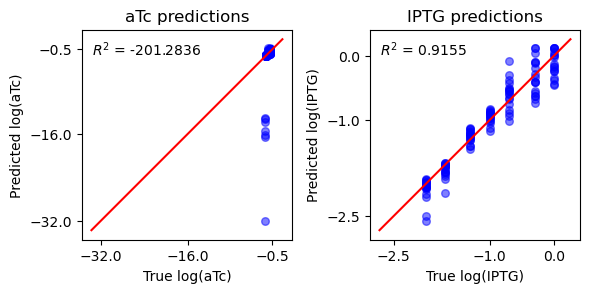

In [23]:
fig,ax=plt.subplots(1,2,figsize=(6,3))

#scale reconstructed and original data back to original scale
original_inputs=np.log10(true_K*normalized_exp_inputs)
predicted_inputs=np.log10(true_K*s_est)

for i in range(original_inputs.shape[1]):
    # Calculate the min and max values
    min_val = np.min([np.min(original_inputs[:,i]),np.min(predicted_inputs[:,i])])
    max_val = np.max([np.max(original_inputs[:,i]),np.max(predicted_inputs[:,i])])
    ticks=[round_to_nearest_half(min_val),round_to_nearest_half((min_val + max_val) / 2),round_to_nearest_half(max_val)]
    min_val_w_ticks=np.min([min_val,np.min(ticks)])
    max_val_w_ticks=np.max([max_val,np.max(ticks)])
    # Calculate the range
    data_range = max_val_w_ticks - min_val_w_ticks
    # Add 5% padding to the min and max values
    padding = 0.05 * data_range
    new_min = min_val_w_ticks - padding
    new_max = max_val_w_ticks + padding

    ax[i].scatter(original_inputs[:,i],predicted_inputs[:,i],s=30,color='blue',alpha=0.5)
    ax[i].plot([new_min, new_max], [new_min, new_max],'r')
    ax[i].set_aspect('equal',adjustable='box')
    ax[i].set_title(f'{input_names[i]} predictions')
    ax[i].set_xticks(ticks)
    ax[i].set_yticks(ticks)
    r2 = r2_score(original_inputs[:, i], predicted_inputs[:,i])
    ax[i].text(0.05, 0.95,fr'$R^2$ = {r2:.4f}', transform=ax[i].transAxes, verticalalignment='top')
    ax[i].set_xlabel(f'True log(' +input_names[i]+')')
    ax[i].set_ylabel(f'Predicted log({input_names[i]})')

plt.tight_layout()
fig.savefig(f'{save_dir}ODE_input_predictions_plotisequalaspectratio.svg',format='svg')
plt.show()

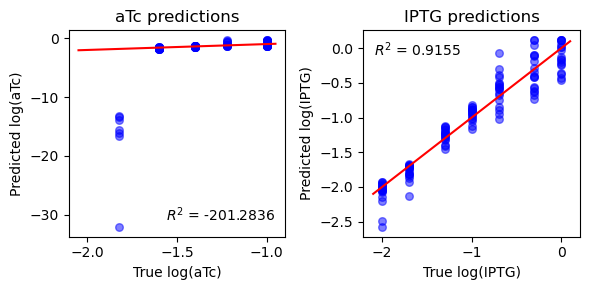

In [30]:
fig,ax=plt.subplots(1,2,figsize=(6,3))

#scale reconstructed and original data back to original scale
original_inputs=np.log10(true_K*normalized_exp_inputs)
predicted_inputs=np.log10(true_K*s_est)

for i in range(original_inputs.shape[1]):
    # Calculate the min and max values
    min_val = np.min(original_inputs[:,i])
    max_val = np.max(original_inputs[:,i])
    ticks=[round_to_nearest_half(min_val),round_to_nearest_half((min_val + max_val) / 2),round_to_nearest_half(max_val)]
    min_val_w_ticks=np.min([min_val,np.min(ticks)])
    max_val_w_ticks=np.max([max_val,np.max(ticks)])
    # Calculate the range
    data_range = max_val_w_ticks - min_val_w_ticks
    # Add 5% padding to the min and max values
    padding = 0.05 * data_range
    new_min = min_val_w_ticks - padding
    new_max = max_val_w_ticks + padding

    ax[i].scatter(original_inputs[:,i],predicted_inputs[:,i],s=30,color='blue',alpha=0.5)
    ax[i].plot([new_min, new_max], [new_min, new_max],'r')
    ax[i].set_title(f'{input_names[i]} predictions')
    ax[i].set_xticks(ticks)
    r2 = r2_score(original_inputs[:, i], predicted_inputs[:,i])
    if i==0:
        ax[i].text(0.45, 0.15,fr'$R^2$ = {r2:.4f}', transform=ax[i].transAxes, verticalalignment='top')
    else:
        ax[i].text(0.05, 0.95,fr'$R^2$ = {r2:.4f}', transform=ax[i].transAxes, verticalalignment='top')
    ax[i].set_xlabel(f'True log(' +input_names[i]+')')
    ax[i].set_ylabel(f'Predicted log({input_names[i]})')

plt.tight_layout()
fig.savefig(f'{save_dir}ODE_input_predictions_plotfitsdata.svg',format='svg')
plt.show()